In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.3.1+cu121


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:,0],z[:,1],s=70,c=color,cmap="Set2")
    plt.show()

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

In [5]:
dataset = Planetoid(root="./tmp/Planetoid", name="Cora", transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [6]:
data = dataset[0] # Get the first graph object

print()
print(data)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [7]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Training a Multi-layer Perception Network (MLP)

In [8]:
from torch.nn import Linear
import torch.nn.functional as F

In [9]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [10]:
model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [11]:
# Define loss criterion
criterion = torch.nn.CrossEntropyLoss()

In [12]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01,
                             weight_decay=5e-4)

In [13]:
def train():
    model.train()
    optimizer.zero_grad() # Clear gradients
    out = model(data.x) # Perform a single forward pass.
    loss = criterion(out[data.train_mask],data.y[data.train_mask]) # Compute the loss solely based on the training nodes.
    loss.backward() # Derive gradients
    optimizer.step() # Update parameters based on gradients
    return loss

In [14]:
def test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1) # Use the class with highest probability
    test_correct = pred[data.test_mask] == data.y[data.test_mask] # Check against ground-truth labels
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) # Derive ratio of correct predictions
    return test_acc

In [15]:
for epoch in range(1,201):
    loss=train()
    if epoch %20==0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 020, Loss: 1.7441
Epoch: 040, Loss: 1.2543
Epoch: 060, Loss: 0.8578
Epoch: 080, Loss: 0.6368
Epoch: 100, Loss: 0.5350
Epoch: 120, Loss: 0.4745
Epoch: 140, Loss: 0.4031
Epoch: 160, Loss: 0.3782
Epoch: 180, Loss: 0.4203
Epoch: 200, Loss: 0.3810


In [16]:
test_acc = test()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.5900


## Training a Graph Neural Network (GNN)

In [17]:
from torch_geometric.nn import GCNConv

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [19]:
model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our untrained GCN network. For visualization, we make use of [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

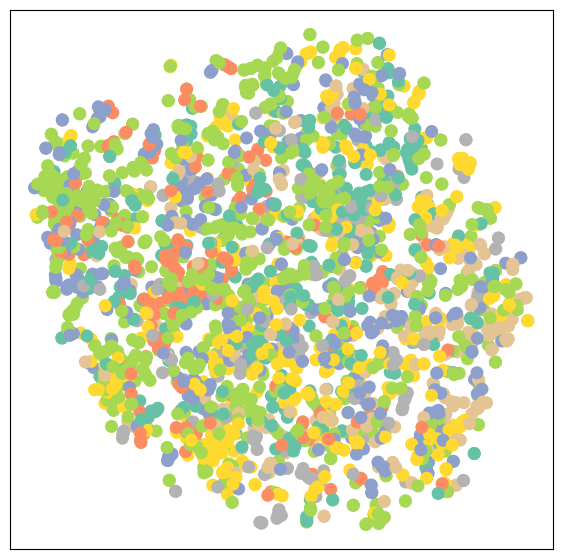

In [20]:
model.eval()

out = model(data.x, data.edge_index)

visualize(out, color=data.y)

In [22]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [30]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


In [24]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 020, Loss: 1.7310
Epoch: 040, Loss: 1.3258
Epoch: 060, Loss: 0.9741
Epoch: 080, Loss: 0.6755
Epoch: 100, Loss: 0.5799
Epoch: 120, Loss: 0.4883
Epoch: 140, Loss: 0.3921
Epoch: 160, Loss: 0.3510
Epoch: 180, Loss: 0.3497
Epoch: 200, Loss: 0.3045


In [25]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


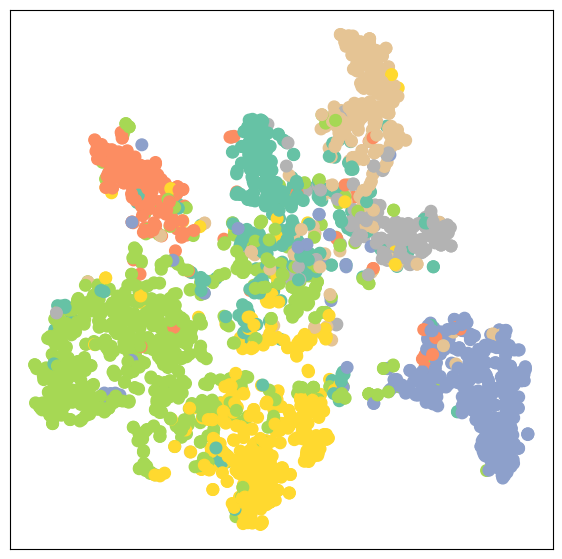

In [26]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

## Exercises

In [36]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [37]:
def eval():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.val_mask] == data.y[data.val_mask]
    test_acc = int(test_correct.sum()) / int(data.val_mask.sum())
    return test_acc

In [38]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 020, Loss: 1.7310
Epoch: 040, Loss: 1.3258
Epoch: 060, Loss: 0.9741
Epoch: 080, Loss: 0.6755
Epoch: 100, Loss: 0.5799
Epoch: 120, Loss: 0.4883
Epoch: 140, Loss: 0.3921
Epoch: 160, Loss: 0.3510
Epoch: 180, Loss: 0.3497
Epoch: 200, Loss: 0.3045


In [39]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8020


In [40]:
eval_acc = eval()
print(f'Eval Accuracy: {eval_acc:.4f}')

Eval Accuracy: 0.7960


In [50]:
# Rebuild model
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

epoch = 0
eval_acc_treshold = 0.8
while True:
    loss = train()
    test_acc = test()
    eval_acc = eval()
    epoch +=1
    if epoch % 20==0:
        print(f'Epoch: {epoch}, Test Accuracy: {test_acc:.4f}, Eval Accuracy: {eval_acc:.4f}')
    if eval_acc > eval_acc_treshold:
        print(f'Eval Accuracy= {eval_acc} > {eval_acc_treshold} at Epoch {epoch}')
        break

Epoch: 20, Test Accuracy: 0.6560, Eval Accuracy: 0.6320
Epoch: 40, Test Accuracy: 0.7800, Eval Accuracy: 0.7620
Epoch: 60, Test Accuracy: 0.8000, Eval Accuracy: 0.7680
Epoch: 80, Test Accuracy: 0.8130, Eval Accuracy: 0.7800
Epoch: 100, Test Accuracy: 0.8150, Eval Accuracy: 0.7780
Epoch: 120, Test Accuracy: 0.8150, Eval Accuracy: 0.7820
Epoch: 140, Test Accuracy: 0.8120, Eval Accuracy: 0.7920
Epoch: 160, Test Accuracy: 0.8100, Eval Accuracy: 0.7840
Eval Accuracy= 0.806 > 0.8 at Epoch 170


In [60]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        # GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        self.conv1 = GATConv(1433, 8, 8, dropout=0.6)  # TODO
        self.conv2 = GATConv(64, 8, 8, dropout=0.6)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

GAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 8, heads=8)
)
Epoch: 001, Loss: 4.1606, Val: 0.1200, Test: 0.1370
Epoch: 002, Loss: 4.1291, Val: 0.1220, Test: 0.1320
Epoch: 003, Loss: 4.0875, Val: 0.1220, Test: 0.1310
Epoch: 004, Loss: 4.0577, Val: 0.1220, Test: 0.1310
Epoch: 005, Loss: 3.9988, Val: 0.1220, Test: 0.1300
Epoch: 006, Loss: 3.9497, Val: 0.1220, Test: 0.1300
Epoch: 007, Loss: 3.8955, Val: 0.1220, Test: 0.1300
Epoch: 008, Loss: 3.8362, Val: 0.1220, Test: 0.1300
Epoch: 009, Loss: 3.7629, Val: 0.1220, Test: 0.1300
Epoch: 010, Loss: 3.6616, Val: 0.1220, Test: 0.1300
Epoch: 011, Loss: 3.5990, Val: 0.1220, Test: 0.1300
Epoch: 012, Loss: 3.5111, Val: 0.1220, Test: 0.1300
Epoch: 013, Loss: 3.4968, Val: 0.1220, Test: 0.1300
Epoch: 014, Loss: 3.3717, Val: 0.1220, Test: 0.1300
Epoch: 015, Loss: 3.2287, Val: 0.1220, Test: 0.1300
Epoch: 016, Loss: 3.0893, Val: 0.1220, Test: 0.1300
Epoch: 017, Loss: 3.0626, Val: 0.1220, Test: 0.1300
Epoch: 018, Loss: 2.9377, Val: 0.1220